In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install MedPy

In [3]:
# Importing all dependencies which we will be using during the prediction

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization,Dropout,Flatten,Conv2D,MaxPooling2D
from sklearn.model_selection import train_test_split
import cv2
import zipfile
import os
from matplotlib import pyplot as plt
import random 
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import matplotlib.image as mpimg
from medpy.filter import smoothing
from tensorflow.keras.optimizers import RMSprop, Adam

from imblearn.over_sampling import SMOTE
from keras.models import Model

from keras.preprocessing import image

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
# Extracting all the folders from the Zip file
with zipfile.ZipFile('/content/drive/MyDrive/archive.zip','r') as zip_file:
  zip_file.extractall('/content/drive/MyDrive/')

FileNotFoundError: ignored

In [5]:

# Loading the train dataset of each class
train_milddemented = ('/content/drive/MyDrive/Alzheimer_s Dataset/train/MildDemented')
train_moderatedemented = ('/content/drive/MyDrive/Alzheimer_s Dataset/train/ModerateDemented')
train_nondemented = ('/content/drive/MyDrive/Alzheimer_s Dataset/train/NonDemented')
train_verymilddemented = ('/content/drive/MyDrive/Alzheimer_s Dataset/train/VeryMildDemented')

Plotting the Mild Dementia Images

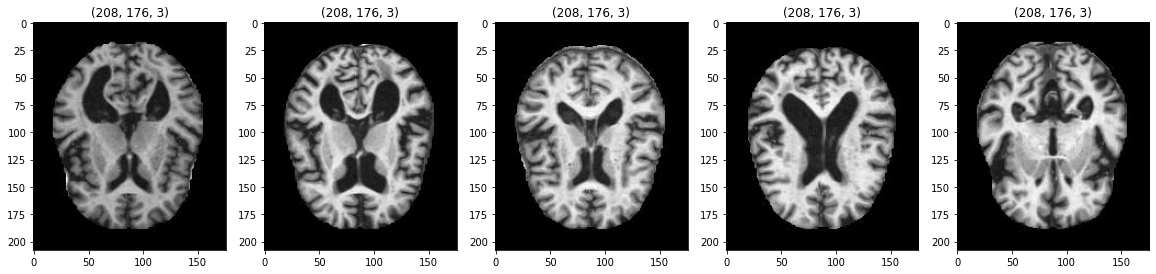

In [6]:

plt.figure(figsize=(20,20)) 
for i in range(5):
    file = random.choice(os.listdir(train_milddemented))
    image_path= os.path.join(train_milddemented, file)
    img=cv2.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    ax.title.set_text(img.shape)
    plt.imshow(img)


Plotting the Moderate Dementia Images


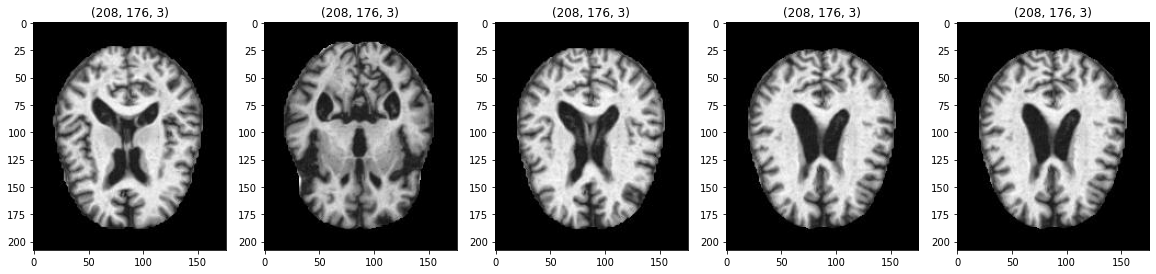

In [7]:

plt.figure(figsize=(20,20)) 
for i in range(5):
    file = random.choice(os.listdir(train_moderatedemented))
    image_path= os.path.join(train_moderatedemented, file)
    img=cv2.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    ax.title.set_text(img.shape)
    plt.imshow(img)

Plotting the Non Dementia Images

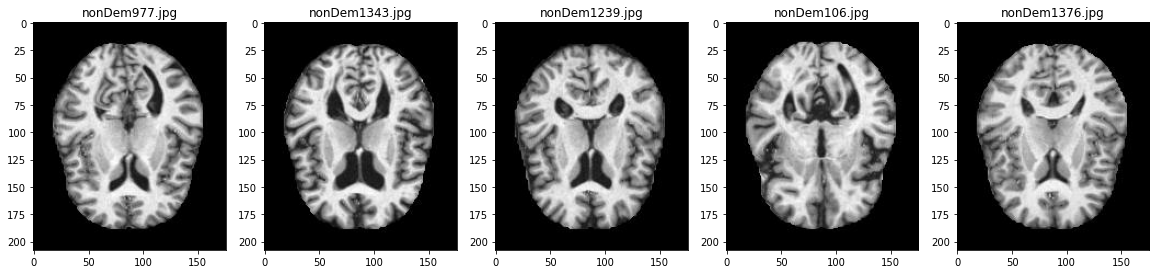

In [8]:

plt.figure(figsize=(20,20)) 
for i in range(5):
    file = random.choice(os.listdir(train_nondemented))
    image_path= os.path.join(train_nondemented, file)
    img=cv2.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

Plotting the Very Mild Dementia Images

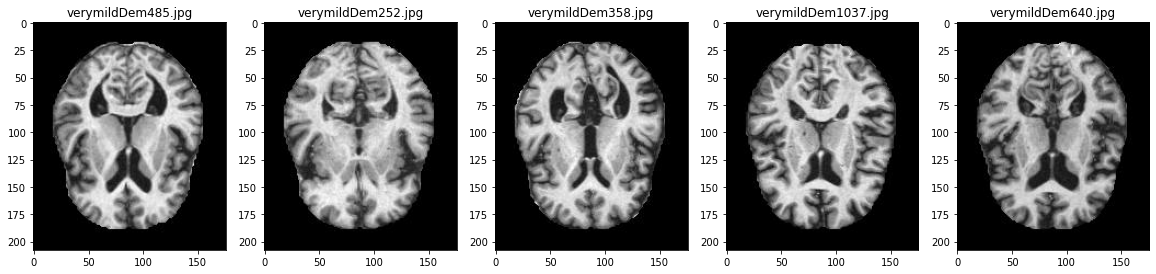

In [9]:
plt.figure(figsize=(20,20)) 
for i in range(5):
    file = random.choice(os.listdir(train_verymilddemented))
    image_path= os.path.join(train_verymilddemented, file)
    img=cv2.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)


In [10]:
# Using Image Data Generator to get Some Random Transformated Images
datagen1 = ImageDataGenerator(rescale = 1./255,rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')
train = datagen1.flow_from_directory('/content/drive/MyDrive/Alzheimer_s Dataset/train', target_size = (224,224),
                                    batch_size = 5200, color_mode='rgb')


Found 5121 images belonging to 4 classes.


In [11]:
datagen1 = ImageDataGenerator(rescale = 1./255)
test = datagen1.flow_from_directory('/content/drive/MyDrive/Alzheimer_s Dataset/test', target_size = (224,224),
                                    batch_size = 1300, color_mode='rgb')

Found 1279 images belonging to 4 classes.


In [12]:

# Total Number of Classes 
train.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [13]:
# Creating a user defined function Which we will be using further to build our convolution Neural Network
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [14]:
# Creating a user Defined Function which contains convolution layers which will be used further to build our convolution Neural Network

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2))
    ]
    )
    
    return block

In [15]:
# Building Our model

def build_model():
    model = tf.keras.Sequential([
        
        
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', input_shape = (224,224,3)),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        
        conv_block(20),
        conv_block(50),
                                  
        
        #conv_block(96),
        #tf.keras.layers.Dropout(0.2),
                                  
        
        #conv_block(256),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
       # dense_block(512, 0.7),
        dense_block(128, 0.3),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    
    return model

In [16]:

model = build_model()

In [17]:
# Summary of the model

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)     

In [18]:
# Defining the metrics to check how our model is performing

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=METRICS)

In [19]:
# Splitting our data into features and labels
train_data, train_labels = train.next()
test_data,test_labels = test.next()

In [20]:
print(train_data.shape)
print(test_data.shape)

(5121, 224, 224, 3)
(1279, 224, 224, 3)


In [ ]:
#Performing over-sampling of the data, since the classes are imbalanced We will get some few more images using this oversampling method

sm=SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 224 * 224 * 3), train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(train_data.shape)
print(test_data.shape)

In [ ]:
# Reshaping the data back to size 224,224
train_data = train_data.reshape(-1, 224, 224, 3)

print(train_data.shape, train_labels.shape)

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
# Fitting the model
history = model.fit(train_data, train_labels, validation_data=(test_data, test_labels), verbose =1 , epochs=10, batch_size= 10)

In [ ]:
# PLOTTING THE LOSS AND ACCURACY OF OUR MODEL

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:

# Saving our model using the keras module

from keras.models import load_model

model.save('/content/drive/MyDrive/alzheimer.h5')

In [ ]:

class_names = ['MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented']

In [ ]:

# Loading the saved model

saved_model = load_model('/content/drive/MyDrive/alzheimer.h5')

# Predicting a random test Image
img = image.load_img('/content/Alzheimer_s Dataset/test/ModerateDemented/29 (2).jpg',target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
img_data = preprocess_input(x)
prediction = model.predict(img_data)
string = "This particular image most likely is :"+class_names[np.argmax(prediction)]
print(string)
plt.imshow(img)
plt.show